# Projet 5 - Catégorisez automatiquement des questions - Notebook Exploratoire

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.corpus import words as nltk_words
from pandarallel import pandarallel
from wordcloud import WordCloud 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import wordninja
from nltk import pos_tag

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download("words")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Fonction 

In [4]:
def info_tokens(tokens):
    """Afficher des infos sur le corpus """
    print(f"Nombre de tokens : {len(tokens)} et nombre de tokens uniques {len(set(tokens))}")
    print(tokens[:30])

## Importation du jeu de données et Nettoyage de nos différents corpus

Requete pour récupérer le jeu de données :
<br>SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount
<br>FROM Posts
<br>WHERE PostTypeId = 1 AND ViewCount > 10 AND Score >= 3 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5

In [5]:
df = pd.read_csv('dataset.csv')

In [6]:
df.head()

,Title,Body,Tags,Id,Score,ViewCount
0,What's a good html e-mail template system that...,<p>We have a web application that periodically...,<java><html><text><templates><email>,468478,4,2351
1,Rows With Different UI Swift and also reusing ...,<p>I am making a layout similar to this <a hre...,<ios><swift><uitableview><storyboard><xib>,39000110,3,331
2,How can I set the colors per value when colori...,"<p>In matplotlib (in particular, pandas), how ...",<python><pandas><matplotlib><colors><seaborn>,39000115,5,5654
3,R: How can I read a CSV file with data.table::...,<p>I got several CSV files which contain numbe...,<r><data.table><fread><read.csv><readr>,39000131,7,7510
4,Run bash script with sh,<p>I have bash script and it requires bash.</p...,<linux><bash><shell><sh><dash-shell>,19538669,18,89968


In [7]:
df.describe()

,Id,Score,ViewCount
count,5.000000e+04,50000.000000,5.000000e+04
mean,2.699523e+07,17.869860,1.695824e+04
std,1.946947e+07,127.205325,9.207491e+04
min,4.000000e+00,3.000000,1.800000e+01
25%,1.091972e+07,3.000000,1.270000e+03
50%,2.265128e+07,5.000000,3.393500e+03
75%,4.087011e+07,9.000000,9.864000e+03
max,7.413322e+07,7621.000000,6.016039e+06


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      50000 non-null  object
 1   Body       50000 non-null  object
 2   Tags       50000 non-null  object
 3   Id         50000 non-null  int64 
 4   Score      50000 non-null  int64 
 5   ViewCount  50000 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.3+ MB


Afin de pouvoir analyser nos différents textes nous allons procéder à un premier nettoyage de ces données. Nous allons effectuer plusieurs opérations afin de rendre notre texte "visible".
Nous allons : 
<br>- Enlever les balises HTML 
<br>- Enlever les caractères inutiles (les "<", les ponctuations et les majuscules)

#### Nettoyage des Tags

In [9]:
def supprimer_balise_tags(tags):
    split = tags.split('><')
    split[0] = split[0][1:]
    split[-1] = split[-1][:-1]
    return split

In [10]:
df['Tags'] = df['Tags'].map(supprimer_balise_tags)

df['nb_tags'] = [len(i) for i in df['Tags']]
df.head()

,Title,Body,Tags,Id,Score,ViewCount,nb_tags
0,What's a good html e-mail template system that...,<p>We have a web application that periodically...,"[java, html, text, templates, email]",468478,4,2351,5
1,Rows With Different UI Swift and also reusing ...,<p>I am making a layout similar to this <a hre...,"[ios, swift, uitableview, storyboard, xib]",39000110,3,331,5
2,How can I set the colors per value when colori...,"<p>In matplotlib (in particular, pandas), how ...","[python, pandas, matplotlib, colors, seaborn]",39000115,5,5654,5
3,R: How can I read a CSV file with data.table::...,<p>I got several CSV files which contain numbe...,"[r, data.table, fread, read.csv, readr]",39000131,7,7510,5
4,Run bash script with sh,<p>I have bash script and it requires bash.</p...,"[linux, bash, shell, sh, dash-shell]",19538669,18,89968,5


In [11]:
print('En moyenne une question possède ', round(df['nb_tags'].mean(),1),'tags')

En moyenne une question possède  5.0 tags


In [12]:
tags_liste = df['Tags'].tolist()

# Aplatissement de la liste de listes
tags = [i for tags in tags_liste for i in tags]

In [65]:
vc_tags = pd.Series(tags).value_counts()

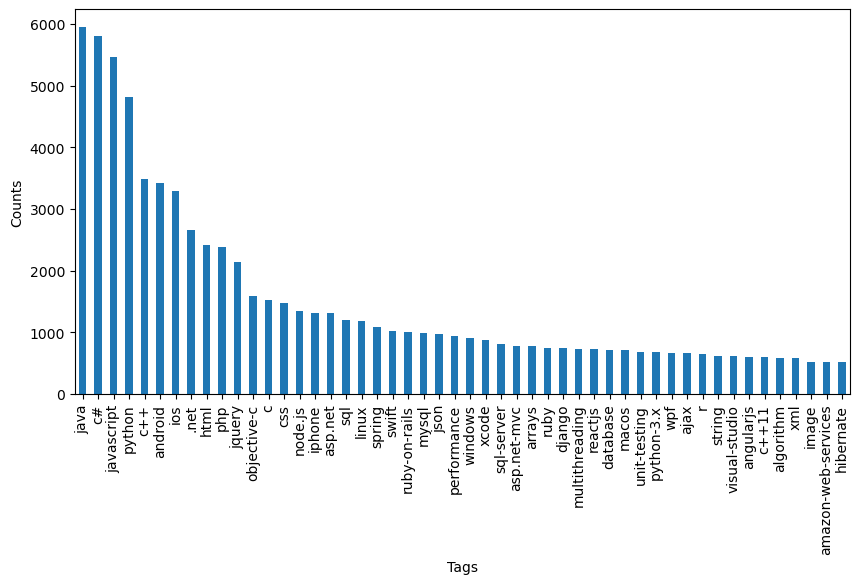

In [66]:
plt.figure(figsize=(10,5))
vc_tags[:50].plot(kind = 'bar')
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

Les tags qui reviennent le plus sont des langages de programmation Java, C#, JavaScript et Python.

In [84]:
from collections import Counter
# Comptez le nombre d'occurrences de chaque tag
compteur_de_tags = Counter(tags)

# Initialisez une liste pour stocker les tags qui répondent à vos critères
liste_tags_2_carac = []

# Parcourez le compteur de tags
for tag, count in compteur_de_tags.items():
    # Vérifiez si le tag a moins de 3 caractères et apparaît plus de 20 fois
    if len(tag) < 3 and count > 50:
        liste_tags_2_carac.append(tag)
len(set(liste_tags_2_carac))

8

### Nettoyage des questions 

In [14]:
# Joindre tous les corpus ensemble
corpus = " ".join(df["Body"].values)

In [15]:
# Tokeniser le texte
tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
liste_tokens = tokenizer.tokenize(corpus)
info_tokens(liste_tokens)

Nombre de tokens : 13572569 et nombre de tokens uniques 407101
['p', 'We', 'have', 'a', 'web', 'application', 'that', 'periodically', 'sends', 'out', 'e', 'mails', 'to', 'users', 'At', 'the', 'moment', 'we', 'generate', 'the', 'html', 'version', 'and', 'the', 'text', 'version', 'in', 'the', 'code', 'However']


In [16]:
vc_tokenize = pd.Series(liste_tokens).value_counts()
vc_tokenize.head(20)

p       552465
code    353125
the     337406
I       259265
to      238362
a       225054
gt      220558
lt      195963
pre     152583
is      126845
and     122050
in      119486
0        98425
of       95880
this     87160
1        82758
it       79991
that     74696
for      68890
with     58362
dtype: int64

Dans les tops mots nous pouvons voir des chiffres. Il faudra donc les supprimer.

In [17]:
vc_tokenize[vc_tokenize==1]

udevadm                           1
operation_encounterIOException    1
HTML_in_XMLHttpRequest            1
DatabaseFactoryDef                1
cachedConstructor                 1
                                 ..
Timo                              1
WillyWonka                        1
WillyNillySiil                    1
Stoinson                          1
Exploder                          1
Length: 188441, dtype: int64

In [18]:
#vc_tokenize.count('processMessageChannel')

In [19]:
# Créez un ensemble de mots anglais
english_words = set(nltk_words.words())

In [20]:
# Définir nos stop_words
stop_words = set(stopwords.words("english"))

In [45]:
def separate_words(text):
    # Utiliser wordninja pour séparer les mots collés
    words = wordninja.split(text)
    return ' '.join(words)
test = 'threewordsjoin'
result = separate_words(test)
result

'three words join'

In [25]:
def process_text_1(text, rejoin=False):
    """Fonction pour nettoyer un corpus de texte"""

    # Supprimer balise HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # Supprimer les liens
    text = re.sub(r"http\S+", "", text)

    # Supprimer les nombres
    text = re.sub(r'\d+', '', text)

    # Mettre en minuscule tous les caractères et supprimer les espaces
    text = text.lower().strip()

    # Divisez le texte en mots uniquement si un mot a plus de 10 caractères
    if len(text) > 10:
        text = separate_words(text)

    # Tokeniser le texte
    tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
    liste_tokens = tokenizer.tokenize(text)

    # Supprimer les stopwords
    liste_tokens_clean = [w for w in liste_tokens if w not in stop_words]

    # Supprimer les mots présents que une seule fois
    liste_tokens_clean = [w for w in liste_tokens if w not in stop_words]

    # Renvoyer une liste de tokens (True) ou bien une chaîne de caractères avec chaque token séparé par un espace (False)
    if rejoin:
        return " ".join(liste_tokens_clean)

    return liste_tokens_clean

In [26]:
corpus_prep_1 = process_text_1(corpus)
print(len(corpus_prep_1))
print(len(set(corpus_prep_1)))

8546397
33416


Avec ce 1er traitement, on divise par 2 le nombre de tokens au total et le nombre de tokens unique

In [27]:
tmp = pd.Series(corpus_prep_1).value_counts()
tmp

get          63343
x            61182
data         57759
id           54900
c            52559
             ...  
jolting          1
scapegoat        1
bunt             1
zipf             1
starfleet        1
Length: 33416, dtype: int64

In [28]:
tmp.head(30)

get        63343
x          61182
data       57759
id         54900
c          52559
class      49859
name       48809
java       47249
view       44126
file       42932
new        41269
set        40626
string     40445
code       39469
type       38165
error      37893
using      37516
app        34961
user       30884
r          30596
value      30495
public     29886
test       29442
use        28988
android    28890
text       27437
v          27388
like       27320
return     27077
f          26898
dtype: int64

In [29]:
tmp.tail(25)

germination    1
floral         1
emergence      1
bynum          1
dedede         1
panics         1
unnerves       1
obsessively    1
transitives    1
dollies        1
ruse           1
hiving         1
servings       1
ridges         1
batur          1
frigg          1
thickens       1
yone           1
seizing        1
venner         1
jolting        1
scapegoat      1
bunt           1
zipf           1
starfleet      1
dtype: int64

In [30]:
tmp.describe()

count    33416.000000
mean       255.757631
std       1681.160634
min          1.000000
25%          2.000000
50%          7.000000
75%         42.000000
max      63343.000000
dtype: float64

<Axes: >

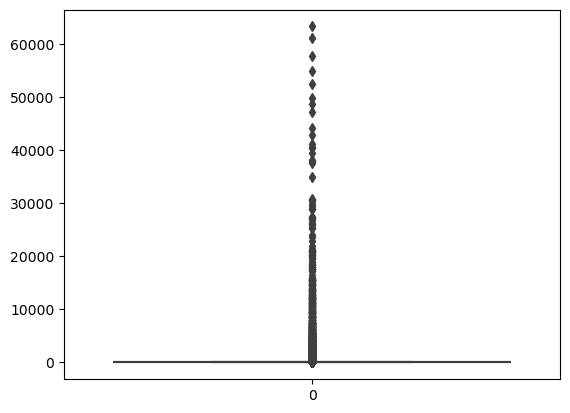

In [31]:
sns.boxplot(tmp)

#### Graphique WordCloud pour observer les mots qui reviennent le plus

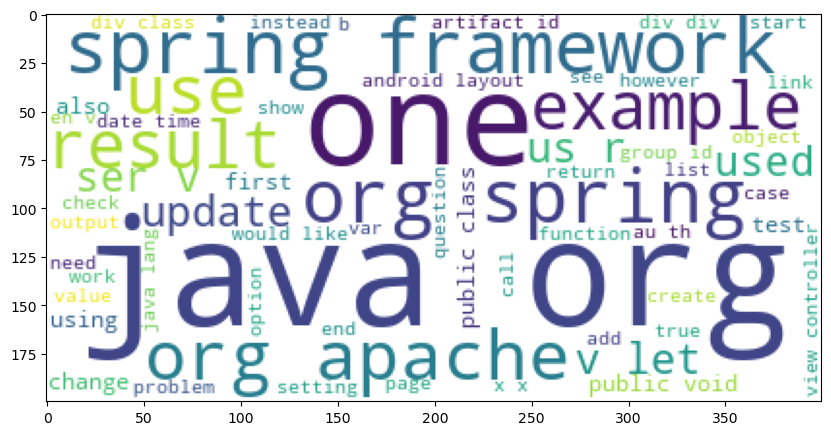

In [32]:
plt.figure(figsize=(10,15))
wordcloud = WordCloud(background_color='white', stopwords=[], max_words=60).generate(" ".join(corpus_prep_1))
plt.imshow(wordcloud)
plt.show()

In [33]:
#Liste des mots qui reviennent que une fois
liste_mot_unique = tmp[tmp==1]

#Liste des mots qui reviennent 5 fois ou moins
liste_mots_5 = tmp[tmp<=5]

#Liste des mots qui reviennent 10 fois ou moins
liste_mots_10 = tmp[tmp<=10]

In [34]:
print(len(liste_mot_unique))
print(len(liste_mots_5))
print(len(liste_mots_10))

6971
15204
18916


On peut noter qu'il n'y a pas une grande différence entre les mots présents 5 fois ou moins et 10 fois ou moins.

#### Enrichissement de notre fonction de nettoyage + Lemmatisation

In [35]:
from nltk.stem import WordNetLemmatizer

In [93]:
def process_text_2(text, rejoin=False, liste_mot_pas_assez_present=None, liste_2_caractere=None,remove_verbs_adverbs=False):
    """Fonction pour nettoyer un corpus de texte"""

    # Supprimer balise HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # Supprimer les liens
    text = re.sub(r"http\S+", "", text)

    # Supprimer les nombres
    text = re.sub(r'\d+', '', text)

    # Mettre en minuscule tous les caractères et supprimer les espaces
    text = text.lower().strip()

    # Divisez le texte en mots uniquement si un mot a plus de 10 caractères
    if len(text) > 10:
        text = separate_words(text)

    # Tokeniser le texte
    tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
    liste_tokens = tokenizer.tokenize(text)

    # Supprimer les stopwords
    liste_tokens_clean = [w for w in liste_tokens if w not in stop_words]

    # Supprimer les mots présents que une seule fois
    liste_tokens_clean = [w for w in liste_tokens_clean if w not in liste_mot_unique]

    # Supprimer liste de mots pas assez présent 
    liste_tokens_clean = [w for w in liste_tokens_clean if w not in liste_mot_pas_assez_present]

    # Supprimer les mots de moins de 2 caractères sauf s'ils sont dans liste_tags_2_carac
    liste_tokens_clean = [w for w in liste_tokens_clean if len(w) > 2 or w in liste_2_caractere]

    if remove_verbs_adverbs:
        # Identifier les parties du discours de chaque mot
        tagged_tokens = pos_tag(liste_tokens_clean)

        # Supprimer les mots qui sont des verbes (VB) ou des adverbes (RB)
        liste_tokens_clean = [w for w, pos in tagged_tokens if pos not in ['VB', 'VBG', 'VBD', 'VBN', 'VBP', 'VBZ']]

    # Lemmatisation des mots (revenir à la racine du mot)
    trans = WordNetLemmatizer()
    trans_text = [trans.lemmatize(w) for w in liste_tokens_clean]

    # Supprimer les stopwords
    trans_text = [w for w in trans_text if w not in stop_words]

    # Renvoyer une liste de tokens (True) ou bien une chaîne de caractères avec chaque token séparé par un espace (False)
    if rejoin:
        return " ".join(trans_text)

    return trans_text

In [37]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [94]:
def clean_data(doc):
    new_doc = process_text_2(doc
                             ,rejoin=True
                             ,liste_mot_pas_assez_present = liste_mots_5
                             ,liste_2_caractere = liste_tags_2_carac 
                             ,remove_verbs_adverbs=False)
    return new_doc

def clean_data_sup_verbe(doc):
    new_doc = process_text_2(doc
                             ,rejoin=True
                             ,liste_mot_pas_assez_present = liste_mots_5
                             ,liste_2_caractere = liste_tags_2_carac 
                             ,remove_verbs_adverbs=True)
    return new_doc

In [90]:
df['Body_clean'] = df.Body.apply(clean_data)

In [95]:
df['Body_clean_sans_verbe'] = df.Body.apply(clean_data_sup_verbe)

In [96]:
df.sample(10)

,Title,Body,Tags,Id,Score,ViewCount,nb_tags,Body_clean,Body_clean_sans_verbe
26019,Access to spreadsheet in deployed web app,<p>I am trying to access a Google spreadsheet ...,"[google-apps-script, google-sheets, web-applic...",28981886,3,1421,5,trying access google spreadsheet via google sc...,access google spreadsheet via google script we...
44264,AttributeError: 'KerasTensor' object has no at...,<p>hi i am making a model for training a datas...,"[python, tensorflow, image-processing, keras, ...",67439263,3,8341,5,making model training datasets net model stuck...,model datasets net model attribute error pleas...
688,using asp.net mvc for REST based endpoint,<p>I'm looking at using ASP.Net MVC as a platf...,"[.net, asp.net, asp.net-mvc, web-services, rest]",573363,5,2664,5,looking using asp net c platform rest based se...,asp net c platform rest service support rest s...
25917,How do I force jquery to center an element whe...,<p>I want some square-shaped draggable objects...,"[javascript, jquery, css, jquery-ui, jquery-ui...",11388679,4,8837,5,want square shaped drag gable object case box ...,want square drag gable object case box number ...
12602,plt.imshow shows color images for grayscale im...,<p><strong>I have the following RGB image</str...,"[image, opencv, matplotlib, ipython, jupyter-n...",41265576,23,32792,5,following rgb image rgb import import mat plot...,rgb image rgb import import mat plot lib plot ...
19738,Functional way of handling resource clean up i...,<p>Hi this is an exmaple of how C# language ha...,"[c#, f#, com, functional-programming, excel-in...",39008385,4,181,5,maple c language handle com inter resource man...,maple c language handle inter resource managem...
40656,Secure JSON Web Token in Web API / MVC 6,<p>The security concerns:\nAccording to <a hre...,"[asp.net-web-api, oauth-2.0, single-page-appli...",31170683,5,2473,5,security concern according lot library use tok...,security concern lot library token order deter...
35474,How do I bind the result of DataTable.Select()...,<p>I have the following code:</p>\n\n<pre><cod...,"[.net, data-binding, listbox, datatable, datarow]",114851,12,31344,5,following code list box data source data set t...,code list box data source data table table nam...
40534,Volunteermatch API Objective C,<p>I am using AFNetworking to perform a web re...,"[ios, objective-c, iphone, http, afnetworking]",33767908,6,951,5,using networking perform web request volunteer...,perform web request volunteer match api perfor...
25051,WP API & ACF - Fetch options page,<p>Currently working on an react project toget...,"[php, wordpress, api, advanced-custom-fields, ...",47224012,4,6240,5,currently working react project together api a...,currently react project together api acf every...


In [98]:
# Exporter le DataFrame au format CSV
df.to_csv('body_preparation.csv', index=False)

# Preparation de Title

## Méthode bag of words - TF/IDF

In [41]:
tfidf = TfidfVectorizer()

In [42]:
tfidf_matrix = tfidf.fit_transform(df['Body_clean'])